# 03. PyTorch computer vision

## Computer vision libraries in PyTorch

* `torchvision` - Base domain library for PyTorch computer vision
* `torchvision.datasets` - Get datasets and data loading functions
* `torchvision.models` - Get pretrained computer vision models
* `torchvision.transforms` - Functions for manipulating images to be suitable for ML models.
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [55]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path
import pandas as pd
import random

## Setup device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting a dataset

The dataset we'll be using if FashionMNIST from `torchvision.datasets`

In [4]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # Where to download data to
    train=True, # Train or test dataset
    download=True,
    transform=ToTensor(), # How do we want to transform the data
    target_transform=None # How do we want to tranform the labels/targets
)

# Setup training data
test_data = datasets.FashionMNIST(
    root="data", # Where to download data to
    train=False, # Train or test dataset
    download=True,
    transform=ToTensor(), # How do we want to transform the data
    target_transform=None # How do we want to tranform the labels/targets
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 174kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.07MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]


In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
# See the first training example
image, label = train_data[0]

image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [7]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [9]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {train_data.classes[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### Visualizing our data

Image shape: torch.Size([1, 28, 28])



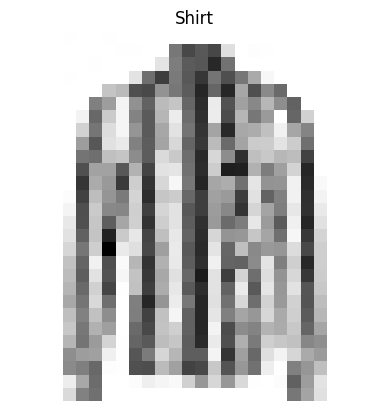

In [10]:
image, label = train_data[int(np.random.rand(1)[0] * 60000)]
print(f"Image shape: {image.shape}\n")
plt.imshow(image.squeeze(), cmap="Greys")
plt.axis(False)
plt.title(train_data.classes[label]);

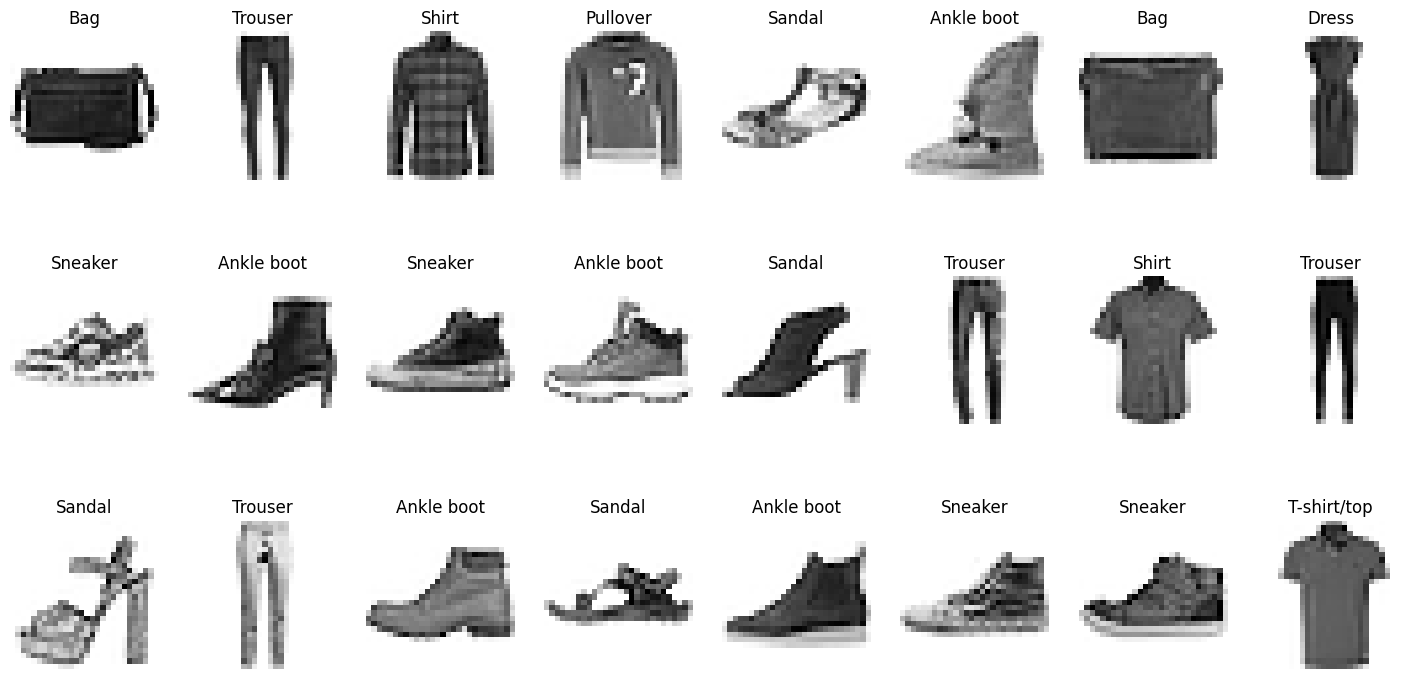

In [11]:
# Plot more images
# torch.manual_seed(42)
fig = plt.figure(figsize=(18, 9))
rows, cols = 3, 8
for i in range(1, rows*cols+1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="Grays")
  plt.title(train_data.classes[label])
  plt.axis(False);

Do you think this items of clothing could be modelled with pure linear lines?
Or do you think we'll need non-linearity?

## Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

1. It is more computationaly efficient, as in, your computing hardware may not be able to store in memory 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural network more chances to update its gradients per epoch.

In [12]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [14]:
# Let's check out what we created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of the train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of the test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ec0683d7350>, <torch.utils.data.dataloader.DataLoader object at 0x7ec070924b50>)
Length of the train_dataloader: 1875 batches of 32
Length of the test_dataloader: 313 batches of 32


In [15]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 7


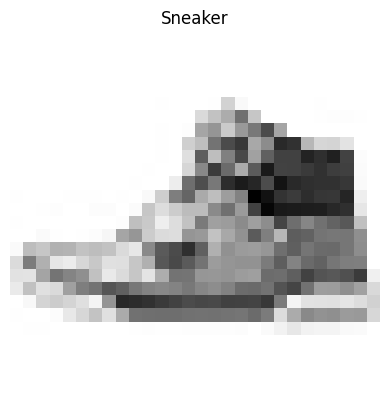

In [16]:
# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="Grays")
plt.title(train_data.classes[label])
plt.axis(False);
print(f"Image size: {img.shape}")
print(f"Label: {label}")

## Model 0: Build a baseline model

When starting to build a series of machine learning experiments, is best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with models/experiments.

In other words: Start simple and add complexity when nescessary.

In [17]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # Perform forward pass
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [18]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layers(x)


In [19]:
# Setup model with input parameters
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784, # 28*28
    hidden_units=10, # number of neurons in the hidden layer
    output_shape=len(train_data.classes) # one for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### Setup loss, optimizer and evaluation metrics

* Loss function - Since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - Our optimizer will be `torch.optim.SGD()`
* Evaluation metric - Since we`re working on a classification problem, let's use accuracy as our evaluation metric

In [21]:
# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("'helper_functions.py' already exists, skipping download...")
else:
  print("Downloading helper_functions.py...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [22]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

### Create a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values)
2. How fast it runs

In [23]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints diference between start and end time."""

  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [24]:
start_time = timer()
# some code...
end_time = timer()

print_train_time(start_time, end_time, "cpu")

Train time on cpu: 0.000 seconds


2.5557000014941877e-05

### Creating a optimizing loop and training the model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform traning steps, calculate the train loss *per batch*.
3. Loop through the testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all (for curiosity).

In [25]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create optimizer loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")

  ### Training
  model_0.train()
  total_train_loss = 0

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    # 1. Forward pass
    train_preds = model_0(X)

    # 2. Calculate the loss
    train_loss = loss_fn(train_preds, y)
    total_train_loss += train_loss # Accumulate the training loss per batch

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    train_loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of train dataloader
  total_train_loss /= len(train_dataloader)

  ### Testing
  model_0.eval()
  total_test_loss, total_test_acc = 0, 0
  with torch.inference_mode():
    for X, y in test_dataloader:
      # 1. Forward pass
      test_preds = model_0(X)

      # 2. Calculate loss
      total_test_loss += loss_fn(test_preds, y)

      # 3. Calculate accuracy
      total_test_acc += accuracy_fn(y_true=y, y_pred=test_preds.argmax(dim=1))

    # Calculate the test loss average per batch
    total_test_loss /= len(test_dataloader)

    # Calculate teh test acc average per batch
    total_test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {total_train_loss:.4f} | Test Loss: {total_test_loss:.4f}, Test acc: {total_test_acc:.4f}%")

  # Calculate the training time
  train_time_end_cpu = timer()
  total_train_time_model_0 = print_train_time(train_time_start_cpu, train_time_end_cpu, str(next(model_0.parameters()).device))
  print()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5904 | Test Loss: 0.5095, Test acc: 82.0387%
Train time on cpu: 8.151 seconds

Epoch: 1
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4763 | Test Loss: 0.4799, Test acc: 83.1969%
Train time on cpu: 16.107 seconds

Epoch: 2
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4550 | Test Loss: 0.4766, Test acc: 83.4265%
Train time on cpu: 24.280 seconds



## Make predictions and get model_0 results

In [26]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):

  """Returns a dictionary containing the results on model predicting on data_loader"""
  loss, acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and accuracy values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y, y_pred.argmax(dim=1))

    # Scale the loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # Only works when model is created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model_0 results on test dataset
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn, device)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Building a better model with non-linear functions

In [27]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layers(x)

model_1 = FashionMNISTModelV1(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(train_data.classes)).to(device)

model_1, next(model_1.parameters()).device

(FashionMNISTModelV1(
   (layers): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): ReLU()
     (3): Linear(in_features=10, out_features=10, bias=True)
     (4): ReLU()
   )
 ),
 device(type='cuda', index=0))

### Functionizing optmizing loops

Let's create a finction for:
* Training loop - `train_step()`
* Testing loop - `test_step()`

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

In [29]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training step with model trying to learn on DataLoader"""

  # Put model on target device and train mode
  model.to(device)
  model.train()

  # Initialize average metric counters
  average_loss, average_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    preds = model(X)

    # 2. Calculate loss/acc per batch
    loss = loss_fn(preds, y)
    average_loss += loss
    average_acc += accuracy_fn(y, preds.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    if batch % (len(dataloader)/10) == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  # Average metrics
  average_loss /= len(dataloader)
  average_acc /= len(dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {average_loss:.5f} | Train acc: {average_acc:.3f}%")

def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing step with model trying to learn on DataLoader"""

  # Put model on target devie and testing mode
  model.to(device)
  model.eval()

  # Initalize average metric counters
  average_loss, average_acc = 0, 0

  with torch.inference_mode():
    for X, y in dataloader:
      # Put data on target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      preds = model(X)

      # 2. Calculate loss/acc
      average_loss += loss_fn(preds, y)
      average_acc += accuracy_fn(y, preds.argmax(dim=1))

    # Average loss and accuracy
    average_loss /= len(dataloader)
    average_acc /= len(dataloader)

  # Print out what's happening
  print(f"Test Loss: {average_loss:.5f} | Test Acc: {average_acc:.3f}%\n")

In [30]:
torch.manual_seed(42)

# Measure time
train_time_start_gpu = timer()

# Set epochs
epochs = 3

# Create optimization loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(
      model=model_1,
      dataloader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      device=device
  )

  test_step(
      model=model_1,
      dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      device=device
  )

train_time_end_gpu = timer()

total_train_time_model_1 = print_train_time(train_time_start_gpu, train_time_end_gpu, next(model_1.parameters()).device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples.
Looked at 12000/60000 samples.
Looked at 24000/60000 samples.
Looked at 36000/60000 samples.
Looked at 48000/60000 samples.

Train loss: 1.11456 | Train acc: 58.463%
Test Loss: 0.96320 | Test Acc: 63.409%

Epoch: 1
---------
Looked at 0/60000 samples.
Looked at 12000/60000 samples.
Looked at 24000/60000 samples.
Looked at 36000/60000 samples.
Looked at 48000/60000 samples.

Train loss: 0.90905 | Train acc: 64.867%
Test Loss: 0.74544 | Test Acc: 72.614%

Epoch: 2
---------
Looked at 0/60000 samples.
Looked at 12000/60000 samples.
Looked at 24000/60000 samples.
Looked at 36000/60000 samples.
Looked at 48000/60000 samples.

Train loss: 0.59508 | Train acc: 78.245%
Test Loss: 0.49708 | Test Acc: 82.768%

Train time on cuda:0: 27.130 seconds


> **Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.
>
> Why is this?
>
> 1. It could be tahat the overhead for copying data/model to and from the GPU outweights the compute benefits offered by the GPU.
> 2. The hardware you're using has better CPU in therm compute capability than the GPU.

In [31]:
model_1_results = eval_model(model_1.to("cpu"), test_dataloader, loss_fn, accuracy_fn, device)
model_0_results, model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

({'model_name': 'FashionMNISTModelV0',
  'model_loss': 0.47663894295692444,
  'model_acc': 83.42651757188499},
 {'model_name': 'FashionMNISTModelV1',
  'model_loss': 0.49707889556884766,
  'model_acc': 82.76757188498402})

## Building a CNN (Convolutional Neural Network)

CNN's are also known as ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

In [32]:
# Create a Convolutional Neural Network
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicatesthe TinyVGG model from CNN explainer website
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # there's a trick to calculate this
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [33]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(train_data.classes)
).to(device)

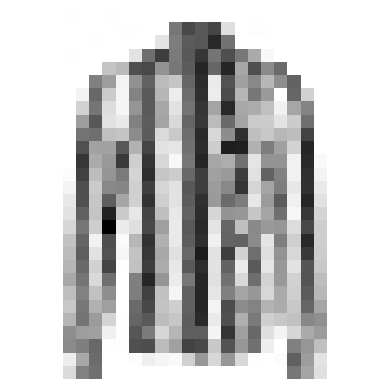

In [34]:
plt.imshow(image.squeeze(), cmap="Grays")
plt.axis(False);

In [35]:
rand_image = torch.rand_like(image).to(device)
rand_image.shape

torch.Size([1, 28, 28])

In [36]:
model_2(rand_image.unsqueeze(dim=0))

tensor([[ 0.0372, -0.0748,  0.0573, -0.0396, -0.0098,  0.0194, -0.0003, -0.0114,
          0.0206,  0.0003]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Stepping through `nn.Conv2d()`


In [37]:
torch.manual_seed(42)
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image: \n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image: 
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [38]:
torch.manual_seed(42)

# Create a single Conv2d layer
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    stride=1,
    padding=0
)

# Pass the data through the conv layer
conv_output = conv_layer(test_image)

test_image.shape, conv_output.shape

(torch.Size([3, 64, 64]), torch.Size([10, 62, 62]))

### Stepping through `nn.MaxPool2d`

In [39]:
# Print out original image shape
print(f"Test image original shape: {test_image.shape}")

Test image original shape: torch.Size([3, 64, 64])


In [40]:
# Create a sample of nn.MaxPool2d layer
maxpool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv layer
test_image_through_conv = conv_layer(test_image)
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the maxpool layer
test_image_through_maxpool = maxpool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and maxpool_layer(): {test_image_through_maxpool.shape}")

Shape after going through conv_layer(): torch.Size([10, 62, 62])
Shape after going through conv_layer() and maxpool_layer(): torch.Size([10, 31, 31])


In [41]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))

# Create a maxpool layer
maxpool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the maxpool layer
maxpool_tensor = maxpool_layer(random_tensor)

print(f"Shape before: {random_tensor.shape}")
print(random_tensor)
print()
print(f"Shape after maxpool layer: {maxpool_tensor.shape}")
print(maxpool_tensor)

Shape before: torch.Size([1, 1, 2, 2])
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])

Shape after maxpool layer: torch.Size([1, 1, 1, 1])
tensor([[[[0.3367]]]])


### Setup loss function and optimizer

In [42]:
# Setup loss function/eval metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.1)

### Traiing and testing `model_2`

In [43]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
start_time = timer()

# Set epochs
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")

  train_step(model=model_2,
             dataloader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_2,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device)

end_time = timer()
total_train_time_model_2 = print_train_time(start=start_time, end=end_time, device=next(model_2.parameters()).device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples.
Looked at 12000/60000 samples.
Looked at 24000/60000 samples.
Looked at 36000/60000 samples.
Looked at 48000/60000 samples.

Train loss: 0.59603 | Train acc: 78.345%
Test Loss: 0.42183 | Test Acc: 84.924%

Epoch: 1
---------
Looked at 0/60000 samples.
Looked at 12000/60000 samples.
Looked at 24000/60000 samples.
Looked at 36000/60000 samples.
Looked at 48000/60000 samples.

Train loss: 0.36212 | Train acc: 86.917%
Test Loss: 0.35565 | Test Acc: 86.821%

Epoch: 2
---------
Looked at 0/60000 samples.
Looked at 12000/60000 samples.
Looked at 24000/60000 samples.
Looked at 36000/60000 samples.
Looked at 48000/60000 samples.

Train loss: 0.32367 | Train acc: 88.187%
Test Loss: 0.32834 | Test Acc: 88.059%

Train time on cuda:0: 32.964 seconds


In [44]:
model_2_results = eval_model(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
model_0_results, model_1_results, model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

({'model_name': 'FashionMNISTModelV0',
  'model_loss': 0.47663894295692444,
  'model_acc': 83.42651757188499},
 {'model_name': 'FashionMNISTModelV1',
  'model_loss': 0.49707889556884766,
  'model_acc': 82.76757188498402},
 {'model_name': 'FashionMNISTModelV2',
  'model_loss': 0.3283396363258362,
  'model_acc': 88.0591054313099})

## Building the defenitive model

In [45]:
# Create a Convolutional Neural Network
class FashionMNISTModelV3(nn.Module):
  """
  Model architecture that replicatesthe TinyVGG model from CNN explainer website
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # there's a trick to calculate this
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [46]:
torch.manual_seed(42)
model_3 = FashionMNISTModelV3(
    input_shape=1,
    hidden_units=25,
    output_shape=len(train_data.classes)
).to(device)

In [47]:
# Setup loss function/eval metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(),
                             lr=0.0005)

In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
start_time = timer()

# Set epochs
epochs = 7

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")

  train_step(model=model_3,
             dataloader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_3,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device)

end_time = timer()
total_train_time_model_3 = print_train_time(start=start_time, end=end_time, device=next(model_3.parameters()).device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples.
Looked at 12000/60000 samples.
Looked at 24000/60000 samples.
Looked at 36000/60000 samples.
Looked at 48000/60000 samples.

Train loss: 0.48771 | Train acc: 82.408%
Test Loss: 0.37042 | Test Acc: 86.961%

Epoch: 1
---------
Looked at 0/60000 samples.
Looked at 12000/60000 samples.
Looked at 24000/60000 samples.
Looked at 36000/60000 samples.
Looked at 48000/60000 samples.

Train loss: 0.32131 | Train acc: 88.365%
Test Loss: 0.32589 | Test Acc: 87.949%

Epoch: 2
---------
Looked at 0/60000 samples.
Looked at 12000/60000 samples.
Looked at 24000/60000 samples.
Looked at 36000/60000 samples.
Looked at 48000/60000 samples.

Train loss: 0.27437 | Train acc: 90.020%
Test Loss: 0.28647 | Test Acc: 89.567%

Epoch: 3
---------
Looked at 0/60000 samples.
Looked at 12000/60000 samples.
Looked at 24000/60000 samples.
Looked at 36000/60000 samples.
Looked at 48000/60000 samples.

Train loss: 0.24657 | Train acc: 91.148%
Test Loss: 0.26848 | Test Acc: 9

In [49]:
model_3_results = eval_model(model=model_3, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)


  0%|          | 0/313 [00:00<?, ?it/s]

## Compare the results and training time

In [50]:
results = pd.DataFrame([model_0_results, model_1_results, model_2_results, model_3_results])
results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.497079,82.767572
2,FashionMNISTModelV2,0.328340,88.059105
3,FashionMNISTModelV3,0.247008,90.854633


In [51]:
# Add training time to results comparison
results["training_time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2, total_train_time_model_3]
results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,24.279500
1,FashionMNISTModelV1,0.497079,82.767572,27.129736
2,FashionMNISTModelV2,0.328340,88.059105,32.963918
3,FashionMNISTModelV3,0.247008,90.854633,80.752378


Text(0, 0.5, 'Model')

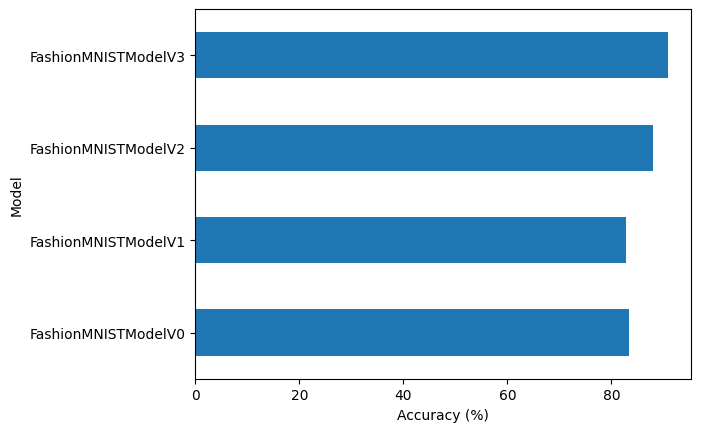

In [53]:
# Visualize our results
results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")

## Make and evaluate random predictions

In [63]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device,
                     ):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass
      pred_logits = model(sample)

      # Get the pred probs
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      # Get pred_probs off GPU for futher calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [78]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

Text(0.5, 1.0, 'Ankle boot')

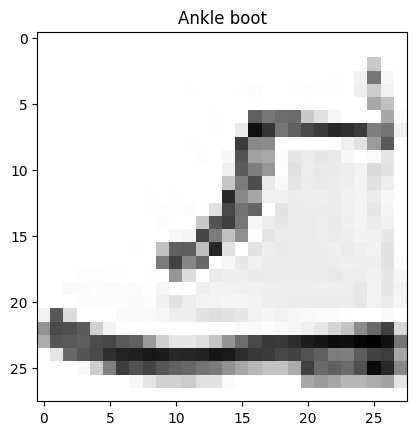

In [79]:
plt.imshow(test_samples[0].squeeze(), cmap="Grays")
plt.title(test_data.classes[test_labels[0]])

In [80]:
# Make predictions
pred_probs = make_predictions(model=model_3,
                              data=test_samples)

# View the first two prediction probabilities
pred_probs[:2]

tensor([[1.4909e-06, 4.2575e-07, 4.3965e-07, 4.7274e-05, 1.0545e-06, 2.4181e-03,
         6.3140e-07, 5.4084e-02, 1.3512e-04, 9.4331e-01],
        [5.1743e-06, 1.5750e-09, 1.4030e-07, 1.1289e-06, 1.4429e-07, 3.1318e-06,
         1.4957e-06, 9.9654e-01, 2.3921e-06, 3.4444e-03]])

In [81]:
pred_labels = torch.argmax(pred_probs, dim=1)
pred_labels

tensor([9, 7, 2, 0, 1, 0, 4, 5, 4])

In [82]:
test_labels

[9, 7, 2, 0, 1, 0, 4, 5, 4]

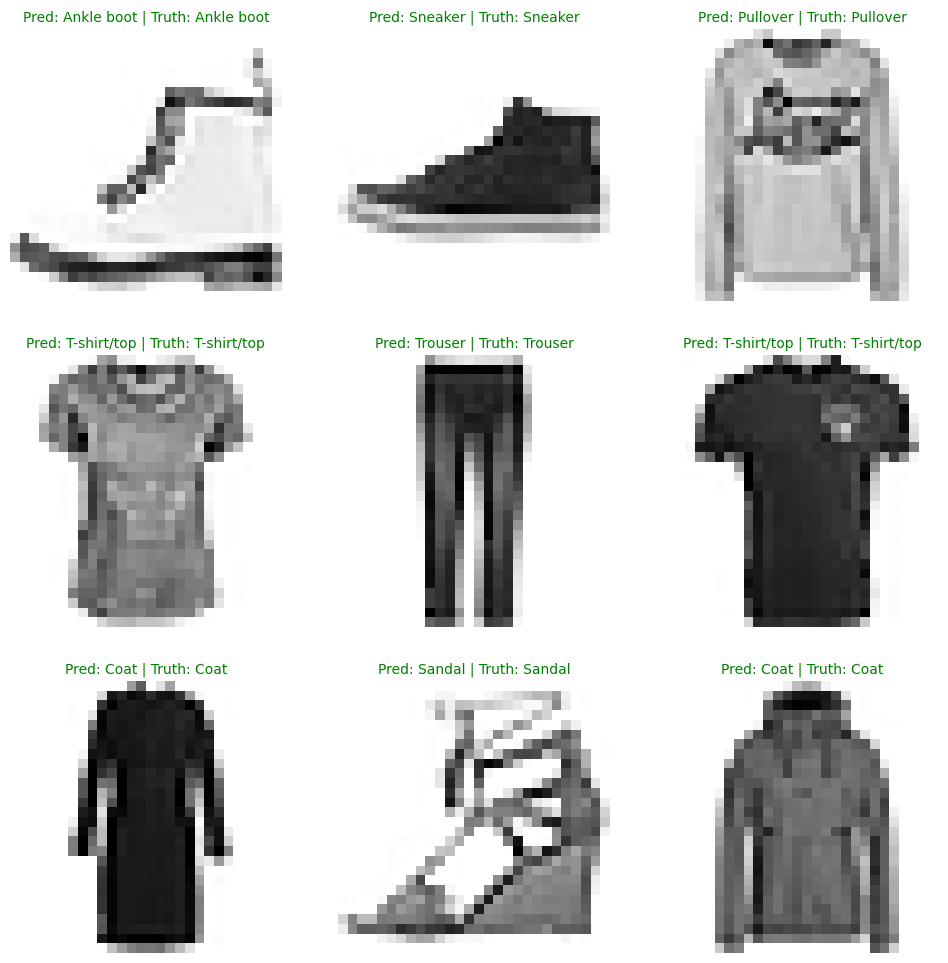

In [83]:
# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="Grays")

  # Find the prediction label in text form
  pred_label = test_data.classes[pred_labels[i]]

  # Get the truth label
  truth_label = test_data.classes[test_labels[i]]

  # Create a title
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  # Aesthetics
  plt.axis(False)

19:00:00